In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
import tensorflow as tf

import iraklis7_nn.config as config
import iraklis7_nn.plots as plots

2026-02-02 15:09:34.662 | INFO     | iraklis7_nn.config:<module>:11 - PROJ_ROOT path is: /Users/iraklis/git/iraklis7_nn


In [3]:
input_path: Path = config.PROCESSED_DATA_DIR
output_path: Path = config.PROCESSED_DATA_DIR 
figures_path: Path = config.FIGURES_DIR

### Load data

In [4]:
# Load predixtions
pred_path  = input_path.joinpath(config.PRED_SET)
y_pred_full = np.loadtxt(str(pred_path))
y_pred = np.array(list(map(np.argmax, y_pred_full)))

In [5]:
# Load test dataset
ds_test_path = input_path.joinpath(config.TEST_SET)
ds_test = tf.data.Dataset.load(str(ds_test_path))
# Create a DataFrame for easier analysis
y_test = [(example.numpy(), label.numpy()) for example, label in ds_test]
df_test = pd.DataFrame(y_test, columns=['example', 'label'])

2026-02-02 15:09:35.247010: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### Map predictions to test dataset labels and images

In [6]:
# Add column for mapping to training dataset
def gen_map(data):
    batch_size = len(df_test['label'].values[0])
    batch_number = int(data/batch_size)
    batch_pos = data - (batch_number*batch_size)
    return (batch_number, batch_pos)

# Create a dataframe that will hold all mis-classifications
df_mcs = pd.DataFrame(y_pred, columns=['predictions'])
df_mcs['prediction_list'] = list(np.argsort(-y_pred_full))
df_mcs['map'] = df_mcs['predictions'].index.to_series().map(gen_map)
df_mcs.sample(5)


,predictions,prediction_list,map
1097,7,"[7, 3, 9, 2, 1, 8, 5, 0, 4, 6]","(8, 73)"
5266,8,"[8, 3, 0, 9, 2, 5, 7, 4, 1, 6]","(41, 18)"
5759,1,"[1, 8, 3, 4, 2, 6, 9, 7, 5, 0]","(44, 127)"
4980,0,"[0, 9, 2, 6, 3, 8, 7, 1, 5, 4]","(38, 116)"
4962,7,"[7, 8, 3, 9, 2, 0, 5, 4, 6, 1]","(38, 98)"


In [7]:
# Using the ds_test map, add a column containing the labels
def find_label(data):
    batch_number = data[0]
    batch_pos = data[1]
    return df_test['label'].values[batch_number][batch_pos]
    #return int(y_test[data[0]][1][data[1]])
    
df_mcs['labels'] = df_mcs['map'].map(find_label)
df_mcs.sample(5)

,predictions,prediction_list,map,labels
1310,9,"[9, 4, 2, 8, 0, 3, 7, 6, 5, 1]","(10, 30)",9
4033,7,"[7, 9, 5, 3, 8, 2, 0, 1, 4, 6]","(31, 65)",7
5298,8,"[8, 2, 3, 4, 9, 6, 5, 7, 0, 1]","(41, 50)",8
1706,3,"[3, 8, 5, 9, 2, 1, 7, 0, 6, 4]","(13, 42)",3
4949,0,"[0, 9, 6, 2, 8, 1, 7, 4, 5, 3]","(38, 85)",0


In [8]:
# Compare predictions and labels and drop matching values
df_mcs.drop(df_mcs[df_mcs.predictions == df_mcs.labels].index, inplace=True)
print(f"Total number of mis-classifications: {len(df_mcs)}")
print(df_mcs.head(5))

Total number of mis-classifications: 161
     predictions                 prediction_list       map  labels
129            1  [1, 4, 8, 9, 3, 2, 5, 7, 6, 0]    (1, 1)       4
198            8  [8, 0, 6, 2, 4, 9, 3, 5, 7, 1]   (1, 70)       0
241            2  [2, 6, 8, 4, 0, 3, 5, 9, 7, 1]  (1, 113)       6
244            6  [6, 8, 2, 5, 0, 9, 4, 3, 7, 1]  (1, 116)       8
263            9  [9, 4, 7, 3, 8, 1, 2, 0, 5, 6]    (2, 7)       4


In [9]:
# Using the ds_test map, add a column containing the images
# We do this at this point, where the dataframe is at its smallest size
def find_images(data):
    batch_number = data[0]
    batch_pos = data[1]
    return df_test['example'].values[batch_number][batch_pos]
    #return y_test[data[0]][0][data[1]]
    
df_sample = df_mcs.sample(30)
df_sample['images'] = df_sample['map'].map(find_images)
df_sample = df_sample.reset_index()
df_sample.head()


,index,predictions,prediction_list,map,labels,images
0,3831,5,"[5, 3, 9, 2, 8, 4, 0, 7, 6, 1]","(29, 119)",8,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0..."
1,4856,6,"[6, 8, 5, 0, 2, 9, 1, 3, 4, 7]","(37, 120)",5,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0..."
2,5502,4,"[4, 6, 7, 8, 9, 2, 1, 5, 3, 0]","(42, 126)",7,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0..."
3,1093,5,"[5, 9, 3, 8, 0, 2, 1, 7, 4, 6]","(8, 69)",3,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0..."
4,5512,6,"[6, 5, 0, 8, 3, 9, 7, 2, 1, 4]","(43, 8)",5,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0..."


### Visualize a sample of failed predictions

2026-02-02 15:09:37.436 | INFO     | iraklis7_nn.plots:plot_bmp_grid:75 - Saving plot to: /Users/iraklis/git/iraklis7_nn/reports/figures/mnist_ds_sample_mc.png


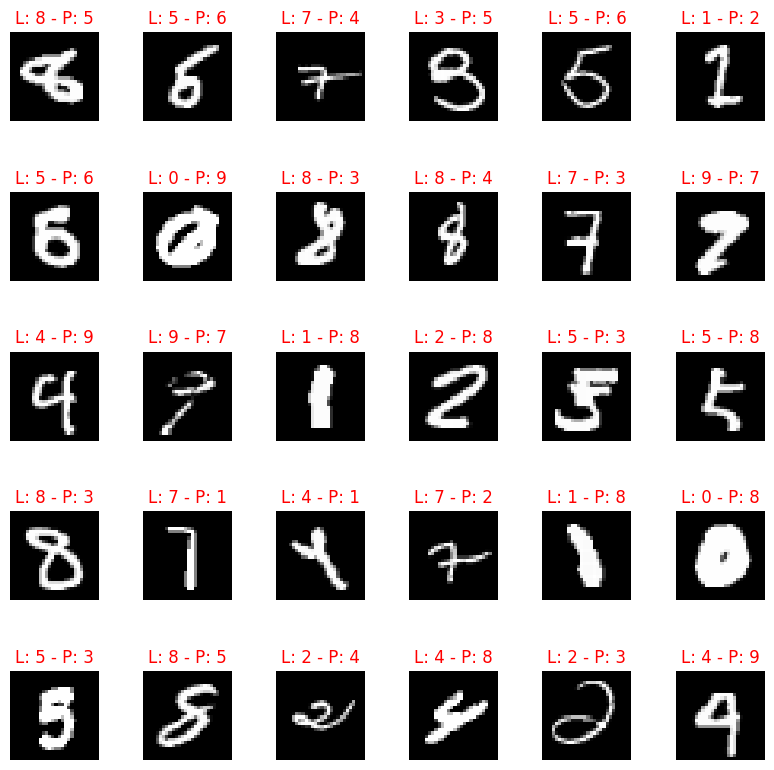

In [10]:
plot_path = figures_path.joinpath(config.SAMPLE_MC_PLOT)
plots.plot_bmp_grid(df_sample.images, df_sample.labels, df_sample.predictions, columns=6, height=8, width=8, show=True, output_path=plot_path)

## Analysis of failed predictions

In [11]:
import duckdb

### Mis-calculation per label

In [12]:
# Count mis-classifications per label
df_mcs_totals = duckdb.query("SELECT labels, count(predictions) FROM df_mcs group by labels order by labels").df() 
print(df_mcs_totals)
import statistics
print(f"Mean of predictions count: {statistics.mean(df_mcs_totals['count(predictions)'])}")

   labels  count(predictions)
0       0                  13
1       1                  11
2       2                  18
3       3                  14
4       4                  18
5       5                  22
6       6                  10
7       7                  21
8       8                  18
9       9                  16
Mean of predictions count: 16.1


2026-02-02 15:09:40.944 | INFO     | iraklis7_nn.plots:plot_xy_bar:31 - Saving plot to: /Users/iraklis/git/iraklis7_nn/reports/figures/mnist_mcs_per_label.png


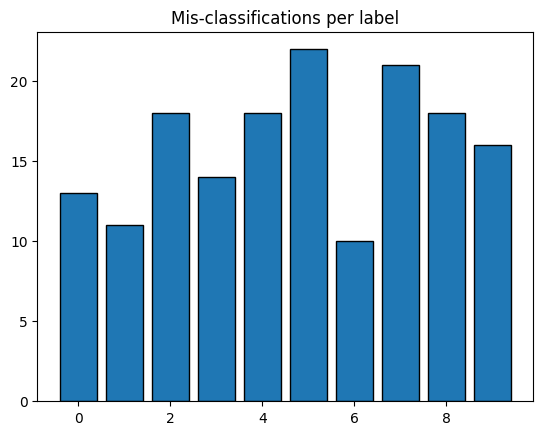

In [13]:
plot_path = figures_path.joinpath(config.MCS_PER_LABEL_PLOT)
plots.plot_xy_bar(df_mcs_totals.labels, df_mcs_totals['count(predictions)'], "Mis-classifications per label", show=True, output_path=plot_path)

### Distribution of mis-classifications per label

In [14]:
df_mcs_pl = duckdb.query("SELECT labels, predictions, count(predictions) FROM df_mcs group by labels, predictions order by labels, predictions").df() 
print(df_mcs_pl)

    labels  predictions  count(predictions)
0        0            2                   1
1        0            3                   1
2        0            5                   3
3        0            6                   2
4        0            8                   2
..     ...          ...                 ...
58       9            3                   2
59       9            4                   6
60       9            5                   1
61       9            7                   3
62       9            8                   2

[63 rows x 3 columns]


### Visualize distribution of mis-classification per label

   labels  predictions  count(predictions)  percentage
0       0            2                   1    7.692308
1       0            3                   1    7.692308
2       0            5                   3   23.076923
3       0            6                   2   15.384615
4       0            8                   2   15.384615
5       0            9                   4   30.769231
2026-02-02 15:09:41.418 | INFO     | iraklis7_nn.plots:plot_pie:16 - Saving plot to: /Users/iraklis/git/iraklis7_nn/reports/figures/mnist_dist_for_0.png


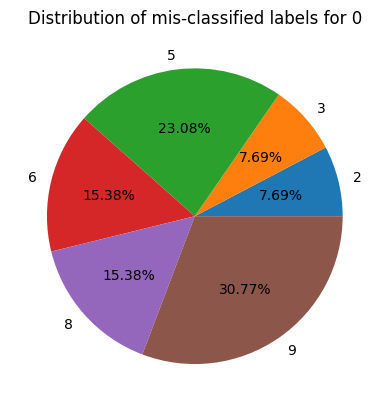

   labels  predictions  count(predictions)  percentage
0       1            2                   2   18.181818
1       1            4                   1    9.090909
2       1            7                   2   18.181818
3       1            8                   6   54.545455
2026-02-02 15:09:41.531 | INFO     | iraklis7_nn.plots:plot_pie:16 - Saving plot to: /Users/iraklis/git/iraklis7_nn/reports/figures/mnist_dist_for_1.png


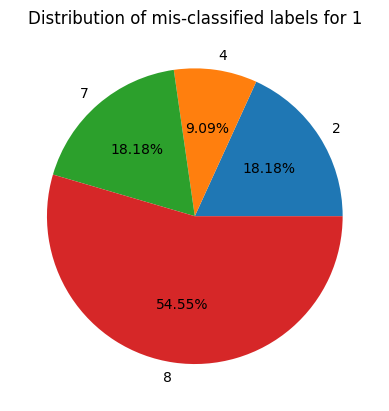

   labels  predictions  count(predictions)  percentage
0       2            0                   1    5.555556
1       2            1                   3   16.666667
2       2            3                   1    5.555556
3       2            4                   2   11.111111
4       2            6                   2   11.111111
5       2            7                   4   22.222222
6       2            8                   4   22.222222
7       2            9                   1    5.555556
2026-02-02 15:09:41.828 | INFO     | iraklis7_nn.plots:plot_pie:16 - Saving plot to: /Users/iraklis/git/iraklis7_nn/reports/figures/mnist_dist_for_2.png


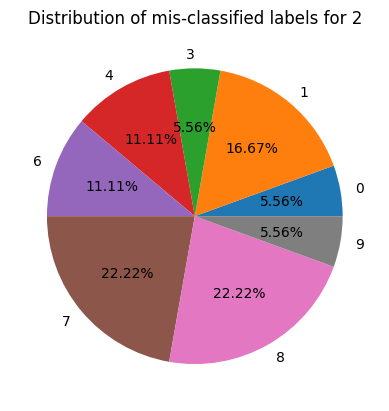

   labels  predictions  count(predictions)  percentage
0       3            2                   6   42.857143
1       3            5                   2   14.285714
2       3            7                   2   14.285714
3       3            8                   3   21.428571
4       3            9                   1    7.142857
2026-02-02 15:09:42.008 | INFO     | iraklis7_nn.plots:plot_pie:16 - Saving plot to: /Users/iraklis/git/iraklis7_nn/reports/figures/mnist_dist_for_3.png


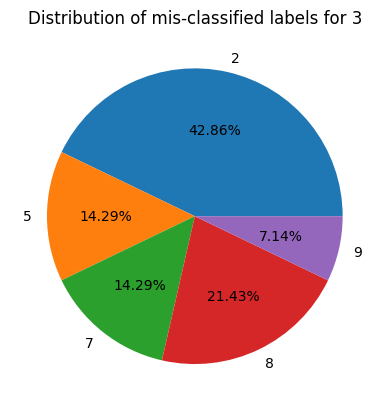

   labels  predictions  count(predictions)  percentage
0       4            1                   2   11.111111
1       4            2                   5   27.777778
2       4            6                   1    5.555556
3       4            7                   1    5.555556
4       4            8                   1    5.555556
5       4            9                   8   44.444444
2026-02-02 15:09:42.180 | INFO     | iraklis7_nn.plots:plot_pie:16 - Saving plot to: /Users/iraklis/git/iraklis7_nn/reports/figures/mnist_dist_for_4.png


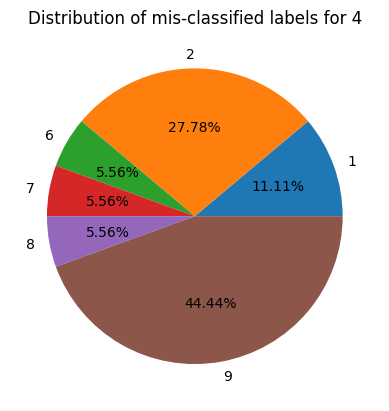

   labels  predictions  count(predictions)  percentage
0       5            3                   8   36.363636
1       5            4                   2    9.090909
2       5            6                   5   22.727273
3       5            8                   5   22.727273
4       5            9                   2    9.090909
2026-02-02 15:09:42.301 | INFO     | iraklis7_nn.plots:plot_pie:16 - Saving plot to: /Users/iraklis/git/iraklis7_nn/reports/figures/mnist_dist_for_5.png


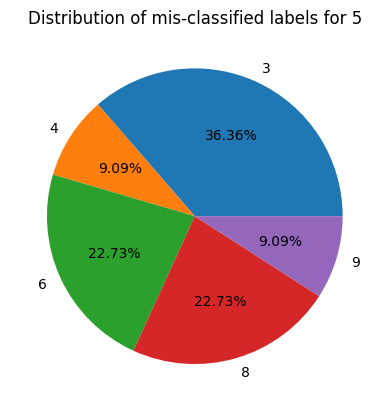

   labels  predictions  count(predictions)  percentage
0       6            0                   2        20.0
1       6            1                   1        10.0
2       6            2                   1        10.0
3       6            4                   2        20.0
4       6            5                   1        10.0
5       6            8                   2        20.0
6       6            9                   1        10.0
2026-02-02 15:09:42.403 | INFO     | iraklis7_nn.plots:plot_pie:16 - Saving plot to: /Users/iraklis/git/iraklis7_nn/reports/figures/mnist_dist_for_6.png


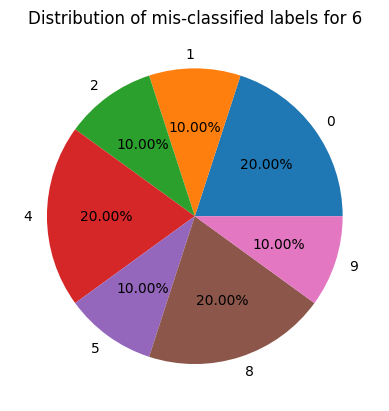

   labels  predictions  count(predictions)  percentage
0       7            0                   1    4.761905
1       7            1                   2    9.523810
2       7            2                   7   33.333333
3       7            3                   3   14.285714
4       7            4                   3   14.285714
5       7            8                   1    4.761905
6       7            9                   4   19.047619
2026-02-02 15:09:42.502 | INFO     | iraklis7_nn.plots:plot_pie:16 - Saving plot to: /Users/iraklis/git/iraklis7_nn/reports/figures/mnist_dist_for_7.png


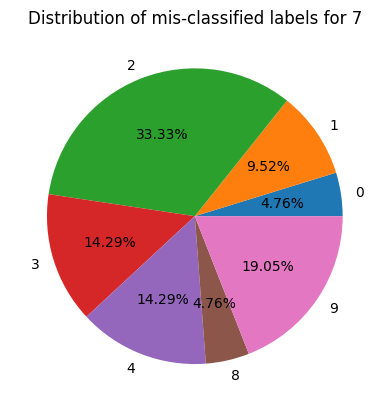

   labels  predictions  count(predictions)  percentage
0       8            0                   1    5.555556
1       8            1                   3   16.666667
2       8            2                   2   11.111111
3       8            3                   3   16.666667
4       8            4                   2   11.111111
5       8            5                   5   27.777778
6       8            6                   1    5.555556
7       8            9                   1    5.555556
2026-02-02 15:09:42.601 | INFO     | iraklis7_nn.plots:plot_pie:16 - Saving plot to: /Users/iraklis/git/iraklis7_nn/reports/figures/mnist_dist_for_8.png


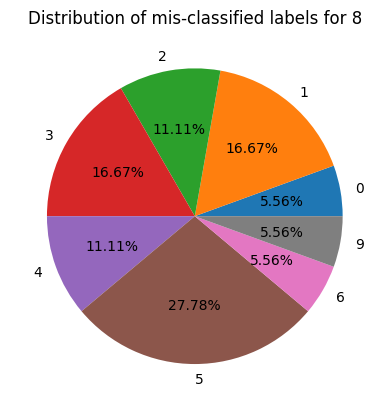

   labels  predictions  count(predictions)  percentage
0       9            0                   1        6.25
1       9            1                   1        6.25
2       9            3                   2       12.50
3       9            4                   6       37.50
4       9            5                   1        6.25
5       9            7                   3       18.75
6       9            8                   2       12.50
2026-02-02 15:09:42.737 | INFO     | iraklis7_nn.plots:plot_pie:16 - Saving plot to: /Users/iraklis/git/iraklis7_nn/reports/figures/mnist_dist_for_9.png


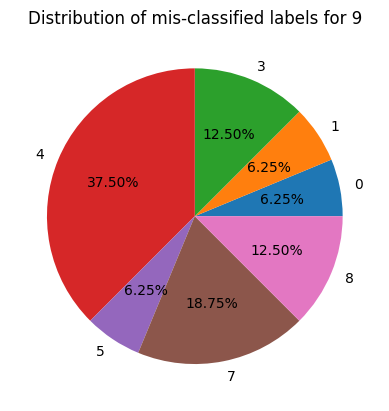

In [15]:
for i in range(10):
    query = f"SELECT labels, predictions, count(predictions), count(*) * 100.0 / sum(count(*)) over() as percentage FROM df_mcs where labels={i} group by labels, predictions order by labels, predictions"
    result = duckdb.query(query).df() 
    print(result)
    cpath =  figures_path.joinpath(config.DIST_PLOT + f"{i}.png")
    plots.plot_pie(result.predictions, result['count(predictions)'], f"Distribution of mis-classified labels for {i}", show=True, output_path=cpath)